In [ ]:
!echo y | pip uninstall h5py
!pip install h5py==2.9.0
!pip install pyscf
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf
from pyscf import fci
from pyscf import cc, mp, dft

# 古典コンピュータを使った量子化学計算を実行してみる

本勉強会の受講者には、量子化学計算に馴染みがない方も多いと思います。
そこで、まずは、「従来型」の量子化学計算に触れていただきます。

## 水素分子の計算（平均場近似と厳密対角化）
ここでは、最も単純な分子である、水素分子(H$_2$)の基底状態を求めてみます。
ソフトウェアには、PySCFというプログラムを用います。
計算方法は、平均場近似（Hartree-Fock)法と、厳密対角化（化学ではFull CIという）をそれぞれ実行してみます。

また、通常の量子化学計算では、有限個のGauss型原子基底関数の線形結合で１電子波動関数（軌道）を記述します (Linear combination of atomic orbitals method, LCAO)。
$$
\psi_i(r) = \sum_{p} C_{ip}\xi_p(r)
$$
この有限個の原子基底関数は、既に標準的に使われているものがいくつもあります。
今回は、その中でも最も単純な、STO-3Gという基底関数を使います。
STO-3Gでは、各水素原子にはそれぞれ１つのｓ型の軌道が使われています。
水素分子としては、２つの「空間」軌道があることになります。
$$
\xi_{1s}(r) = \sum_{i=1}^3 d_{i,1s}g_{1s}(a_i,r)
$$
さて、電子にはスピンの自由度があるので、↑と↓のスピンの自由度ごとに空間軌道に電子が入ります。
スピンの自由度がごとに入る軌道をスピン軌道といいます。
$$
\chi(x) = 
\begin{cases}
\psi(r)\alpha(\omega) \\
\textrm{or} \\
\psi(r)\beta(\omega)
\end{cases}
$$
スピン軌道は空間軌道の２倍の数があります。STO-3G基底関数を使った場合、
水素分子には4つのスピン軌道があることになります。
水素には電子が２つあるので、電子があるスピンに存在する場合を１、しない場合を０としましょう。
すると、電子の詰まり方（電子配置は）、0011, 0101, 1001, 1100, 1010, 0110
の6パターンが存在することがわかります。


平均場近似では、電子の波動関数は一つのSlater行列式（一つの電子配置）であらわされます。
つまり、先程の６パターンうち１つの電子配置しか取らないと仮定して（例えば、0011)、
その仮定のもとでエネルギーが最小化される軌道を見つけます。


厳密対角化（Full CI)では、全ての取りうる電子配置を考えて、その重ね合わせで、
波動関数を表現します。
$$
|\Phi_{\textrm{CI}}\rangle = c_{0011}|\Psi_{0011}\rangle + c_{0101}|\Psi_{0101}\rangle + c_{1001}|\Psi_{1001}\rangle + c_{1100}|\Psi_{1100}\rangle + c_{1010}|\Psi_{1010}\rangle + c_{0110}|\Psi_{0110}\rangle
$$
今回の例では電子配置の数は少ないですが、電子配置の数は組み合わせ爆発をおこしますので、
計算コストは指数関数的に増大します。


さて、まず平均場（Hartree-Fock）計算を実行してみましょう。


In [3]:
# 水素分子、H-H距離は0.74Å と設定。STO-3GというGaussian型の原子基底関数を使用。
mol_h2 = gto.M(atom = 'H 0 0 0; H 0 0 0.74', basis = 'sto-3g')
# この水素分子の基底状態を平均場近似（Hartree-Fock theory)で計算してみる。
mean_filed_wavefunction = scf.RHF(mol_h2)
mean_filed_wavefunction.verbose = 0
hf_energy = mean_filed_wavefunction.kernel()
print ("Hartree-Fock Energy in (hartree)", hf_energy)

Hartree-Fock Energy in (hartree) -1.1167593073964253


次に、厳密対角化（Full CI)の計算をおこないます。

In [4]:
full_ci_wavefunciton = fci.FCI(mean_filed_wavefunction)
fci_energy, fci_eigenvector = full_ci_wavefunciton.kernel()
print ("Full CI Energy (in hartree)", fci_energy)
print ("Hartree Fock/Full CI Energy (in %)", hf_energy/fci_energy*100)

Full CI Energy (in hartree) -1.1372838344885028
Hartree Fock/Full CI Energy (in %) 98.19530301322638


# 電子相関と電子相関エネルギー

与えられたハミルトニアンに対する厳密解（Full CI)と平均場で解いたときのエネルギー（Hartree-Fockエネルギー）は、非常に近いことがわかる。平均場という単純な近似で、Full CIエネルギーの98.2%を再現している。一般におおよそ、Hartree-Fockは、全エネルギーの約99%を再現できると言われている。残りの約1%を電子相関エネルギーと呼ぶ。

この電子相関エネルギー(Electron Correlation Energy)を見てみよう。

In [5]:
electron_correlation_energy = fci_energy - hf_energy
print ("Electron Correlation Energy in (hartree)", electron_correlation_energy)
print ("Electron Correlation Energy in (eV)", electron_correlation_energy*27.2114)
print ("Electron Correlation Energy in (kcal/mol)", electron_correlation_energy*23.0605*27.2114)

Electron Correlation Energy in (hartree) -0.020524527092077527
Electron Correlation Energy in (eV) -0.5585011165133584
Electron Correlation Energy in (kcal/mol) -12.879314997356303


# 電子相関エネルギーと化学的精度

電子相関は、約0.56eV（13 kcal/mol)となっている。
さて、熱エネルギー（ボルツマン因子の逆数 $1/\beta = k_bT$; $k_b$はボルツマン定数）は、室温298.15Kで約0.026eV (0.59kcal/mol)である。 熱エネルギーと比べると、電子相関のエネルギーは非常に大きい値であることがわかる。


分子の安定性（存在比）や、化学反応速度は、状態間のエネルギー差を$\Delta E$とするとボルツマン分布$e^{-\beta \Delta E}$に比例し、エネルギー差に対して指数的に減少（増大）する。
+/- 0.56eV (13kcal/mol)ほど、$\Delta E$に誤差があるとすれば、正解となる反応速度を１としたときに、誤差に応じて以下のように大きく変動する。

In [6]:
print ("誤差が 0.56eVあったときの反応速度 %1.1e" %np.exp(-0.56/0.026))
print ("誤差が-0.56eVあったときの反応速度 %1.1e" %np.exp(0.56/0.026))

誤差が 0.56eVあったときの反応速度 4.4e-10
誤差が-0.56eVあったときの反応速度 2.3e+09


さて、誤差が 1kca/mol (約0.043eV)以下であった場合はどうだろう？

In [7]:
print ("誤差が1kcal/mol(0.043eV)あったときの反応速度 %1.1e" %np.exp(-0.043/0.026))
print ("誤差が1kcal/mol(-0.043V)あったときの反応速度 %1.1e" %np.exp(0.043/0.026))

誤差が1kcal/mol(0.043eV)あったときの反応速度 1.9e-01
誤差が1kcal/mol(-0.043V)あったときの反応速度 5.2e+00


反応速度は、室温の場合、おおよそオーダーではあうことがわかる。
少なくとも、「反応速度（や存在比）のオーダーは予測できること」＝「化学における定量的計算」とするならば、量子化学の計算において目指すべき誤差はこの「1kcal/mol」となることがわかる。

# 代表的なその他の量子化学計算手法


さて、では、計算の定量性を増すにはどうすればいいのだろうか？ 
厳密にハミルトニアンを解く方法 Full CIは指数関数的な計算コストが必要となる。
このコストを下げるために、量子化学では、様々な近似理論が開発されてきた。
ここでは、計算コストが$O(N^5)$の二次の摂動論MP2、
現在の量子化学の「Golden standard」と称される$O(N^7)$の CCSD(T)、
そして、計算コストが$O(N^3)$で業界標準の方法となっているDFTという3つの手法を、
厳密な方法(Full CI)と比較してみよう。

水素分子は簡単過ぎるので、H$_4$という系を考えてみる。

In [8]:
%%capture
hf_energies = []
mp2_energies = []
ccsdt_energies = []
fci_energies = []
dft_energies = []
r_list = []
for i in range(15):
  # H4、H-H距離を変化。STO-3GというGaussian型の原子基底関数を使用。
  r=0.5+i*0.15
  mol_h4 = gto.M(atom = 'H 0 0 0; H 0 0 %f; H 0 0 %f; H 0 0 %f' %(r,r*2,r*3),
  basis = 'sto-3g')
  # この水素分子の基底状態を平均場近似（Hartree-Fock theory)で計算してみる。
  mean_filed_wavefunction = scf.RHF(mol_h4)
  mean_filed_wavefunction.verbose = 0
  hf_energy = mean_filed_wavefunction.kernel()
  dft_wavefunction = dft.RKS(mol_h4)
  dft_wavefunction.verbose = 0
  dft_wavefunction.xc = 'B3LYP'
  dft_energy = dft_wavefunction.kernel()
  mp2_energy = mp.MP2(mean_filed_wavefunction).kernel()[0] + hf_energy
  ccsd_wavefunction = cc.RCCSD(mean_filed_wavefunction)
  ccsd_wavefunction.kernel()
  ccsdt_energy = ccsd_wavefunction.ccsd_t() + ccsd_wavefunction.e_tot
  full_ci_wavefunciton = fci.FCI(mean_filed_wavefunction)
  fci_energy, fci_eigenvector = full_ci_wavefunciton.kernel()
  hf_energies.append(hf_energy)
  mp2_energies.append(mp2_energy)
  ccsdt_energies.append(ccsdt_energy)
  fci_energies.append(fci_energy)
  dft_energies.append(dft_energy)
  r_list.append(r)


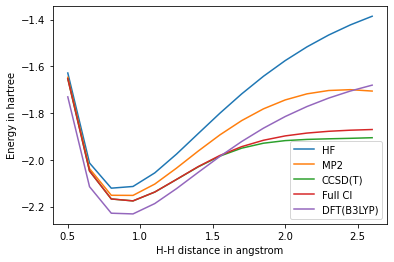

In [9]:
plt.plot(r_list, hf_energies, label="HF")
plt.plot(r_list, mp2_energies, label="MP2")
plt.plot(r_list, ccsdt_energies, label="CCSD(T)")
plt.plot(r_list, fci_energies, label="Full CI")
plt.plot(r_list, dft_energies, label="DFT(B3LYP)")
plt.ylabel("Energy in hartree")
plt.xlabel("H-H distance in angstrom")
plt.legend()
plt.show()

DFTは、電子密度に依存する'ad hoc'なポテンシャルをHatree-Fockに導入した理論と捉えることができる。DFT自体は変分法であるが、この追加したポテンシャルのために、DFTのエネルギーの絶対値はFull CIの解よりも低いエネルギーを与えうる。

CCSD(T)は、H-Hの距離が長くなるところ（強相関領域）では、厳密解との乖離が大きくなるが、H-H距離が短いところではFull CIと良好な一致をしめしていることがわかる。

CCSD(T)は優れた理論であり、それ故に'Golden standard'と称されるわけだが、電子相関が強い領域で破綻する（もしくは精度が低下する）ことが知られている。
一般に電子相関が強い領域を定量的に記述することは大変であり、
満足のいく量子化学理論は未だに存在しない。

これが量子コンピュータに期待が集まる背景である。